# **Predicting Amtoisation Energy with Ridge Regression**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Visualising molecules
To visualise the dataset, we used pyplot's 3d projection combined with a  scatterplot to plot the nuclei. To correctly plot the bonds, we first determined the distances of all atoms in a molecule using the eculidian distance of each atom pair. Since the distances between the atoms seem to be arbitrary and not in Ångström (the typically used unit to measure bond length), we needed to manually check for a few bond types the different bond lengths to determine, whether the bond length corresponded to a single, double or triple bond. Furthermore, since bond length also depends on the atoms participating in the bond, we manually checked for the different atom combinations and determined thresholds for single, double and triple bonds. The algorithm generally predicts and visualises the bondtype well, but in some rare cases where sterics affect bond length, this approach leads to falsely identifying carbon-carbon single bonds as carbon-carbon double bounds.
Running the code in an actual python environment enables one to freely turn the plotted molecules inside the grid to get a better look at their geometry and the bondtypes.

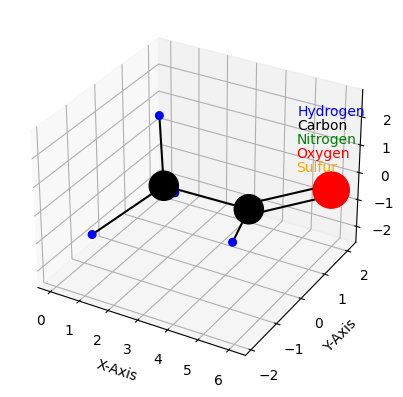

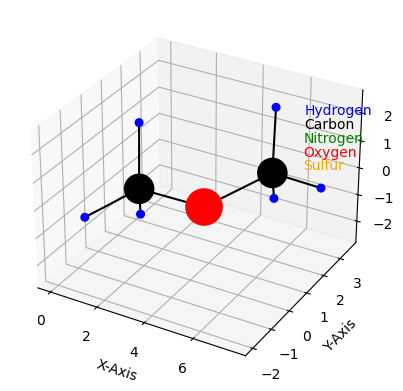

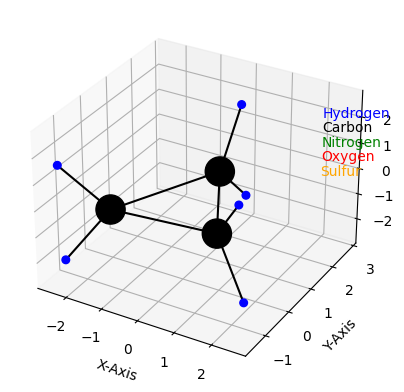

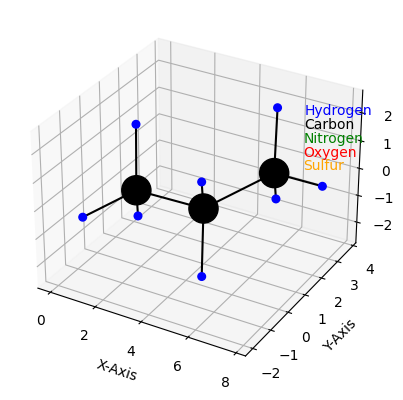

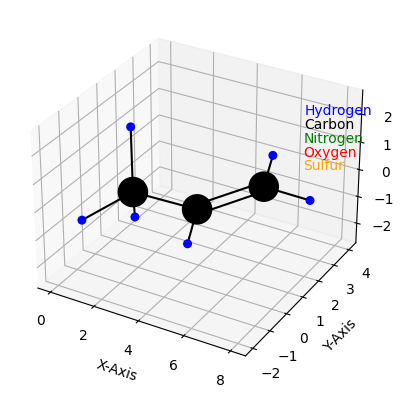

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
import urllib.request
import os

url = "http://quantum-machine.org/data/qm7.mat"
filename = "qm7.mat"
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)

# Load the dataset
dataset = scipy.io.loadmat(filename)

# Get the 3D coordinates of atoms in molecules
R = dataset['R'] # shape: (7165, 23, 3)

# Get the atomic numbers of atoms in molecules
Z = dataset['Z'] # shape: (7165, 23)
Z = np.array(Z, dtype=int)

# Get the atomization energy of molecules
T = dataset['T'] # shape: (1, 7165)
T = T[0]

atomnumber = {1:"H", 6:"C", 7:"N", 8:"O", 16:"S"}
atomcolor = {0: "white", 1:"blue", 6:"black", 7:"green", 8:"red", 16:"orange"}


def bondlist(atoms, coordinates):
    bonds = np.zeros((atoms.size, atoms.size)) # initialise matrix that contains all bonds, 1 = single bond, 2 = double bond, 3 = triple bond
    for i in range(atoms.size):
        for j in range(atoms.size):
            if i != j:
                coordi = np.array([coordinates[:,0][i], coordinates[:,1][i], coordinates[:,2][i]])
                coordj = np.array([coordinates[:,0][j], coordinates[:,1][j], coordinates[:,2][j]])
                if (atoms[i] == 1 and atoms[j] == 6) or (atoms[i] == 6 and atoms[j] == 1): #C-H bond
                    if np.linalg.norm(coordi - coordj) < 2.5:
                        bonds[i,j] = 1
                elif (atoms[i] == 6 and atoms[j] == 6): # CC bond
                    if np.linalg.norm(coordi - coordj) < 2.3: #triple bond
                        bonds[i,j] = 3
                    elif np.linalg.norm(coordi - coordj) < 2.6: #double bond
                        bonds[i,j] = 2
                    elif np.linalg.norm(coordi - coordj) < 3: #single bond
                        bonds[i,j] = 1
                elif (atoms[i] == 7 and atoms[j] == 6) or (atoms[i] == 6 and atoms[j] == 7): #CN bond
                    if np.linalg.norm(coordi - coordj) < 2.25:  # double bond
                        bonds[i, j] = 3
                    elif np.linalg.norm(coordi - coordj) < 2.85:  # double bond
                        bonds[i, j] = 1
                elif (atoms[i] == 8 and atoms[j] == 6) or (atoms[i] == 6 and atoms[j] == 8): #CO bond
                    if np.linalg.norm(coordi - coordj) < 2.4:  # double bond
                        bonds[i, j] = 2
                    elif np.linalg.norm(coordi - coordj) < 2.75:  # double bond
                        bonds[i, j] = 1
                elif (atoms[i] == 16 and atoms[j] == 6) or (atoms[i] == 6 and atoms[j] == 16): # CS bond
                    if np.linalg.norm(coordi - coordj) < 3.5: #single bond
                        bonds[i,j] = 1
                elif (atoms[i] == 8 and atoms[j] == 1) or (atoms[i] == 1 and atoms[j] == 8): # OH bond
                    if np.linalg.norm(coordi - coordj) < 2: #single bond
                        bonds[i,j] = 1
                elif (atoms[i] == 7 and atoms[j] == 1) or (atoms[i] == 1 and atoms[j] == 7): # NH bond
                    if np.linalg.norm(coordi - coordj) < 2.1: #single bond
                        bonds[i,j] = 1
                elif (atoms[i] == 7 and atoms[j] == 8) or (atoms[i] == 8 and atoms[j] == 7): # NO bond
                    if np.linalg.norm(coordi - coordj) < 2.7: #single bond
                        bonds[i,j] = 1
                elif (atoms[i] == 16 and atoms[j] == 7) or (atoms[i] == 7 and atoms[j] == 16): # SN bond
                    if np.linalg.norm(coordi - coordj) < 3.3: #single bond
                        bonds[i,j] = 1
                elif (atoms[i] == 16 and atoms[j] == 8) or (atoms[i] == 8 and atoms[j] == 16): # SO bond
                    #print("S0 bond: ", np.linalg.norm(coordi - coordj))
                    if np.linalg.norm(coordi - coordj) < 2.85:  # double bond
                        bonds[i,j] = 2
                    # if np.linalg.norm(coordi - coordj) < 3.3: #single bond
                    #     bonds[i,j] = 1
    for i in range(atoms.size): #check for aromates, if aromate exists change bond type to 4 = aromatic bond
        if atoms[i] == 6:
            if sum(bonds[i,:]) > 4:
                for j in range(atoms.size):
                    if i != j:
                        if atoms[j] == 6 and bonds[i,j] == 2:
                            bonds[i,j] = 4
    return bonds


def plotmolecule(coordinates, atoms):
    bonds = bondlist(atoms, coordinates)
    maxim = True
    xmax = max(coordinates[:,0])
    ymax = max(coordinates[:,1])
    zmax = max(coordinates[:,2])
    zmin = min(coordinates[:,2])
    if zmax == 0 and zmin == 0:
        zspan = 3
        zmax = 1.5
        zmin = -1.5
        maxim = False
    else:
        zspan = abs(zmax - zmin)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], c=[atomcolor.get(j) for j in atoms],
               depthshade=False,s=((atoms) ** 1.5) * 30)
    if maxim:
        ax.text(xmax - (0.2 * xmax), ymax, zmax, s="Hydrogen", c="blue")
        ax.text(xmax - (0.2 * xmax), ymax, zmax - (0.15 * zspan), s="Carbon", c="black")
        ax.text(xmax - (0.2 * xmax), ymax, zmax - (0.3 * zspan), s="Nitrogen", c="green")
        ax.text(xmax - (0.2 * xmax), ymax, zmax - (0.45 * zspan), s="Oxygen", c="red")
        ax.text(xmax - (0.2 * xmax), ymax, zmax - (0.6 * zspan), s="Sulfur", c="orange")
    else:
        ax.text(xmax - (0.2 * xmax), ymax, zmax + 1, s="Hydrogen", c="blue")
        ax.text(xmax - (0.2 * xmax), ymax, zmax + 1 - (0.15 * zspan), s="Carbon", c="black")
        ax.text(xmax - (0.2 * xmax), ymax, zmax + 1 - (0.3 * zspan), s="Nitrogen", c="green")
        ax.text(xmax - (0.2 * xmax), ymax, zmax + 1 - (0.45 * zspan), s="Oxygen", c="red")
        ax.text(xmax - (0.2 * xmax), ymax, zmax + 1 - (0.6 * zspan), s="Sulfur", c="orange")
    for i in range(atoms.size):
        for j in range(atoms.size):
            if i > j:
                if bonds[i,j] == 1: #single bond
                    ax.plot([coordinates[i,0], coordinates[j,0]], [coordinates[i,1], coordinates[j,1]], [coordinates[i,2], coordinates[j,2]], c="black")
                elif bonds[i,j] == 2: #double bond
                    vec1 = coordinates[j]-coordinates[i]
                    orthogonal1 = np.cross(vec1, [1,1,1])
                    vec2 = coordinates[i] - coordinates[j]
                    orthogonal2 = np.cross(vec2, [1,1,1])
                    p11 = coordinates[i]+(orthogonal1*(1/(5*np.linalg.norm(orthogonal1))))
                    p12 = coordinates[i]-(orthogonal1*(1/(5*np.linalg.norm(orthogonal1))))
                    p21 = coordinates[j] + (orthogonal2*(1/(5*np.linalg.norm(orthogonal2))))
                    p22 = coordinates[j] - (orthogonal2*(1/(5*np.linalg.norm(orthogonal2))))
                    ax.plot([p11[0], p22[0]], [p11[1], p22[1]],[p11[2], p22[2]], c="black")
                    ax.plot([p21[0], p12[0]], [p21[1], p12[1]],[p21[2], p12[2]], c="black")
                elif bonds[i,j] == 3: #triple bond
                    vec1 = coordinates[j]-coordinates[i]
                    orthogonal1 = np.cross(vec1, [2,2,2])
                    vec2 = coordinates[i] - coordinates[j]
                    orthogonal2 = np.cross(vec2, [3,3,3])
                    p11 = coordinates[i]+0.1*orthogonal1*(1/(np.linalg.norm(orthogonal1)))
                    p12 = coordinates[i]-0.1*orthogonal1*(1/(np.linalg.norm(orthogonal1)))
                    p21 = coordinates[j] + 0.1*orthogonal2*(1/(np.linalg.norm(orthogonal2)))
                    p22 = coordinates[j] - 0.1*orthogonal2*(1/(np.linalg.norm(orthogonal2)))
                    ax.plot([coordinates[i, 0], coordinates[j, 0]], [coordinates[i, 1], coordinates[j, 1]],
                            [coordinates[i, 2], coordinates[j, 2]], c="black")
                    ax.plot([p11[0], p22[0]], [p11[1], p22[1]],[p11[2], p22[2]], c="black")
                    ax.plot([p21[0], p12[0]], [p21[1], p12[1]],[p21[2], p12[2]], c="black")
                elif bonds[i,j] == 4: #aromatic bond
                    vec1 = coordinates[j]-coordinates[i]
                    orthogonal1 = np.cross(vec1, [1,1,1])
                    vec2 = coordinates[i] - coordinates[j]
                    orthogonal2 = np.cross(vec2, [1,1,1])
                    p11 = coordinates[i]+(orthogonal1*(1/(5*np.linalg.norm(orthogonal1))))
                    p12 = coordinates[i]-(orthogonal1*(1/(5*np.linalg.norm(orthogonal1))))
                    p21 = coordinates[j] + (orthogonal2*(1/(5*np.linalg.norm(orthogonal2))))
                    p22 = coordinates[j] - (orthogonal2*(1/(5*np.linalg.norm(orthogonal2))))
                    ax.plot([p11[0], p22[0]], [p11[1], p22[1]],[p11[2], p22[2]], c="black")
                    ax.plot([p21[0], p12[0]], [p21[1], p12[1]],[p21[2], p12[2]], c="black", ls=":")
    ax.set_xlabel("X-Axis")
    ax.set_ylabel("Y-Axis")
    ax.set_zlabel("Z-Axis")
    ax.set_zlim(zmin-1,zmax+1)
    plt.show()

for i in range(5,10):
  plotmolecule(R[i], Z[i])


# 2. Data Representation, ML Model and Explanations

**Data Representation**

All molecules were transformed into one-hot encodings.

In [ ]:
def onehot(atoms):
    hashmap = {1:0, 6:1, 7:2, 8:3, 16:4}
    out = np.zeros(5)
    for i in atoms:
        if int(i) != 0:
            out[hashmap.get(i)] += 1
    return out


onehotlist = np.zeros([Z.shape[0],5])

for i in range(Z.shape[0]):
    onehotlist[i,:] = onehot(Z[i])

print(onehotlist)

[[ 4.  1.  0.  0.  0.]
 [ 6.  2.  0.  0.  0.]
 [ 4.  2.  0.  0.  0.]
 ...
 [ 9.  6.  1.  0.  0.]
 [10.  7.  0.  0.  0.]
 [12.  7.  0.  0.  0.]]


**Ridge Regression Model**

Minimisation of the weights is performed using the formula of part 2.2 in the project sheet.

In [ ]:
def minimise_w(x, lambd,t):
    autovariate = np.matmul(np.transpose(x),x)
    t = t
    identity = np.identity(x.shape[1])
    lambd = lambd
    covariate = np.matmul(np.transpose(x), t)
    w = np.matmul(np.linalg.inv(autovariate+np.multiply(lambd,identity)),covariate)
    return w

def regress_func(x,w):
  return np.matmul(np.transpose(w),x)


# 3. Experiments

**Simple atom-based Representation**

The obtained one-hot encodings were used to perform Ridge Regression.
To minimise testing error, we performed 10 fold cross validation of the dataset using lambdas between 0.01 and 6.3. The optimal lambda that minimises the mean MSE of the testing data was determined to be 4.94. The overall mean absolute error for prediction is 15.79 kcal/mol.
Subsequent plotting of predicted vs actual atomisation energies of the first 1000 molecules of the dataset show that this model already does a good job predicting the real atomisation energy values.

The predicted influence of each atom type on the atomisation energies are plotted below. Since atomisation energy can not be measured for a single atom and there is (to our knwoledge) no chemical equivalent to the observed influence of each atom to the overall atomisation energy, explaining the predictions of this model and transferring them to the real world is hardly possible. In general it seems like Carbon atoms have the strongest effect on atomisation energies but this could be due to the fact that the dataset consists only of organic compounds, i.e. compounds containing at least one carbon atom.

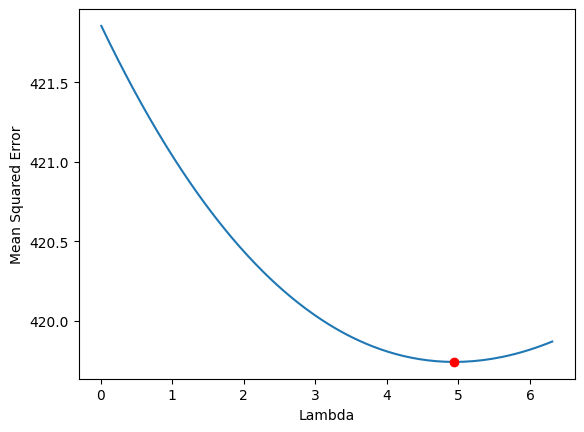

w_onehot:  [ -68.69916308 -153.77153101  -98.9264007   -97.76446062  -75.67132315]
optimal lambda_onehot:  4.936132098237917
MSE:  410.54791306470617
Mean absolute error:  15.792200388634699


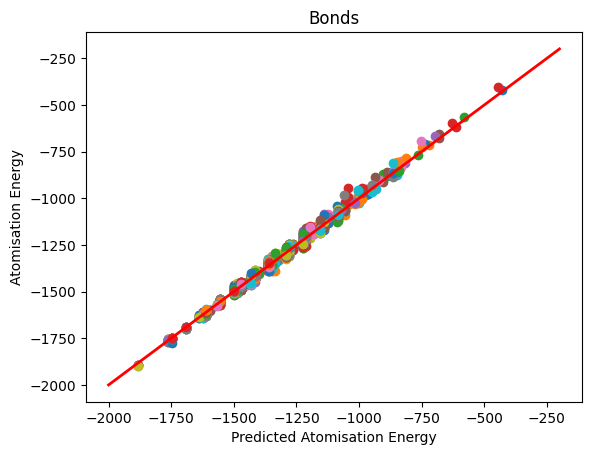

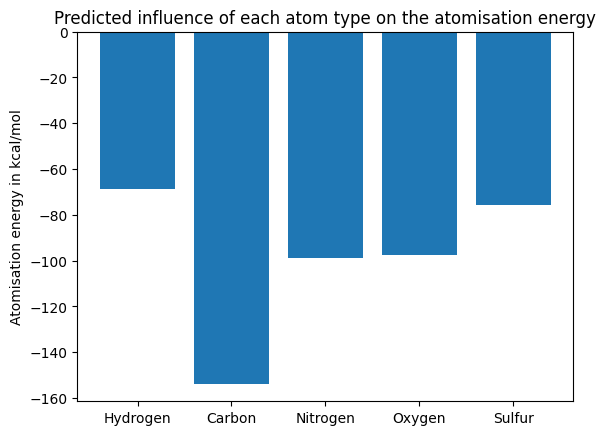

In [ ]:
k_fold = 10
lambdalist = np.logspace(-2,0.8,num=500)
mselist = np.zeros(500)
a = int(onehotlist.shape[0]/k_fold)

for count, j in enumerate(lambdalist):
  mselistinside = np.zeros(k_fold)
  for k in range(k_fold):
    training = np.concatenate((onehotlist[:k*a], onehotlist[(k+1)*a:]))
    test = onehotlist[k*a:(k+1)*a]
    trainingT = np.concatenate((T[:k*a], T[(k+1)*a:]))
    testT = T[k*a:(k+1)*a]
    w = minimise_w(training, j, trainingT)
    A2 = np.zeros(testT.shape)
    for i in range(A2.shape[0]):
      A2[i] = regress_func(test[i], w)
    mselistinside[k] = (np.square(A2 - testT)).mean(axis=0)
  mselist[count] = np.mean(mselistinside)


optimal_lambda_onehot = lambdalist[np.argmin(mselist)]
w_onehot = minimise_w(onehotlist, optimal_lambda_onehot, T)

plt.plot(lambdalist, mselist)
plt.plot(optimal_lambda_onehot, np.min(mselist), 'ro')
plt.ylabel("Mean Squared Error")
plt.xlabel("Lambda")
plt.show()
print("w_onehot: ", w_onehot)
print("optimal lambda_onehot: ", optimal_lambda_onehot)
A_onehot = np.zeros(T.shape)
for i in range(A_onehot.shape[0]):
  A_onehot[i] = regress_func(onehotlist[i], w_onehot)
mse_onehot = (np.square(A_onehot - T)).mean(axis=0)
print("MSE: ", mse_onehot)
abs_error_onehot = (np.absolute(A_onehot - T)).mean(axis=0)
print("Mean absolute error: ", abs_error_onehot)

for i in range(1000):
    plt.scatter(regress_func(onehotlist[i],w_onehot), T[i])

plt.plot([-2000, -200],[-2000,-200], c="red", linewidth=2)
plt.ylabel("Atomisation Energy")
plt.xlabel("Predicted Atomisation Energy")
plt.title("Bonds")
plt.show()

atomlist = ["Hydrogen", "Carbon", "Nitrogen", "Oxygen", "Sulfur"]
plt.bar(atomlist, w_onehot)
plt.title("Predicted influence of each atom type on the atomisation energy")
plt.ylabel("Atomisation energy in kcal/mol")
plt.show()

**Models with Pairs of Atoms**

Since finetuning the hyperparameters was computationally expensive, the following code has been optimised for quicker computation.
First, the distances between all atoms in each molecule were calculated and written in a 23x23 matrix. The matrix was then flattened to only contain the upper triangular matrix, i.e. only the distances between each set of different atoms and removing duplicates, e.g. removing pairs like (atom 2,atom 1) when the pair (atom 1, atom 2) is already present in the data. Furthermore to speed up subsequent computation, a second matrix of the same size was created that contains the atom types involved in the bonds, e.g. carbon-carbon or carbon-hydrogen.


In [ ]:
distance_matrix = np.zeros([Z.shape[0], 23*11])
for k in range(R.shape[0]):

  dist_mat = np.zeros([Z.shape[1], Z.shape[1]])

  for i in range(R.shape[1]):
    for j in range(R.shape[1]):
      if Z[k,i] != 0 and Z[k,j] != 0:
        dist_mat[i,j] = np.linalg.norm(np.array([R[k,i,0], R[k,i,1], R[k,i,2]])-np.array([R[k,j,0], R[k,j,1], R[k,j,2]]))
  dist_mat = dist_mat[np.triu_indices(23, k = 1)]
  distance_matrix[k,:] += dist_mat


pairtypes = np.array([[100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,0 ,100000,100000,100000,100000,1,2,3,100000,100000,100000,100000,100000,100000,100000,4],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,1,100000,100000,100000,100000,5,6,7,100000,100000,100000,100000,100000,100000,100000,8],
                      [100000,2,100000,100000,100000,100000,6,9,10,100000,100000,100000,100000,100000,100000,100000,11],
                      [100000,3,100000,100000,100000,100000,7,10,12,100000,100000,100000,100000,100000,100000,100000,13],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000],
                      [100000,4,100000,100000,100000,100000,8,11,13,100000,100000,100000,100000,100000,100000,100000,14]])

index_list = np.zeros([Z.shape[0], 23*11], dtype = int)
for k in range(R.shape[0]):
  ind_list = np.full([Z.shape[1], Z.shape[1]], fill_value = 1000)
  for i in range(Z.shape[1]):
    for j in range(Z.shape[1]):
      if Z[k,i] != 0 and Z[k,j] != 0:
        ind_list[i,j] = pairtypes[Z[k,i], Z[k,j]]
  ind_list = ind_list[np.triu_indices(23, k = 1)]
  index_list[k,:] = ind_list


In the next step, we wanted to finetune the hyperparameters number of intervals, variance of the gaussian function in the intervals and lambda for each variance and number of intervals. Preliminary experiments showed that 53 to 60 intervals combined with a variance between 0.01 and 0.03 lead to a minimisation of mean absolute prediction error. We used 5 fold cross validation of the dataset to speed up computation and checked with lambdas from 0.32 to 63, as preliminary experiments showed that the minimal absolute prediction error is presumed for lambda values in this range.
For each number of intervals the mean absolute prediction error was plotted against each tested variance and with already determined optimal lambda (i.e. the lambda, that optimised the mean absolute prediction error for each variance).
Finally, the obtained data was pickled and downloaded.

clustersize =  53


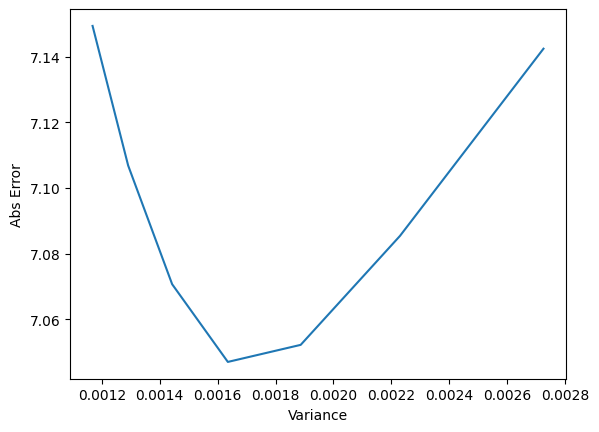

clustersize =  54


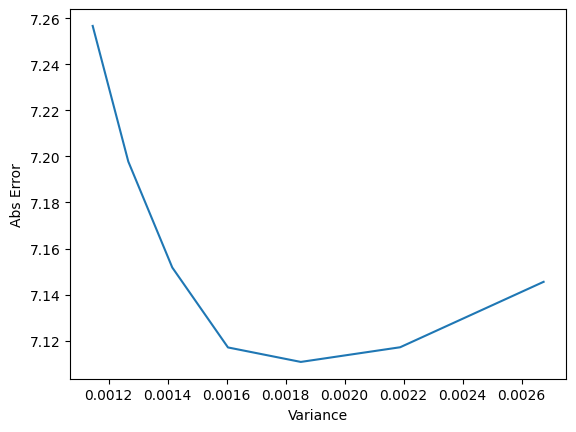

clustersize =  55


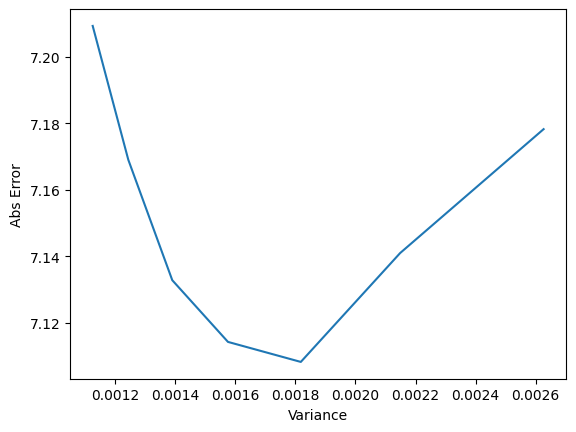

clustersize =  56


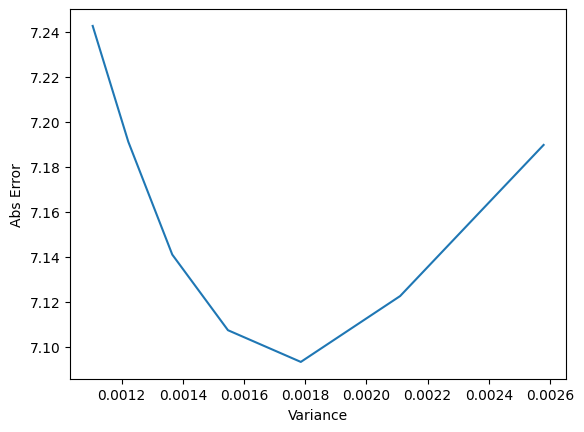

clustersize =  57


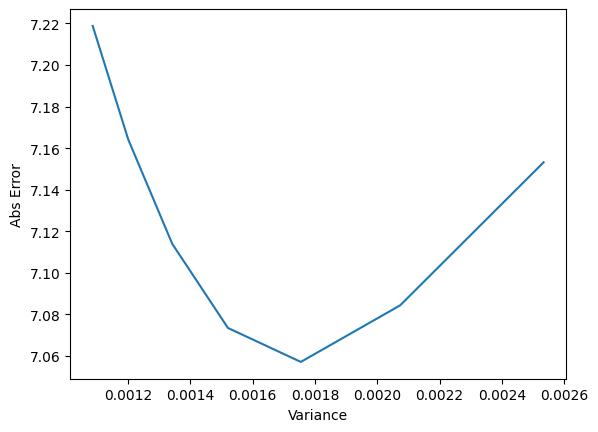

clustersize =  58


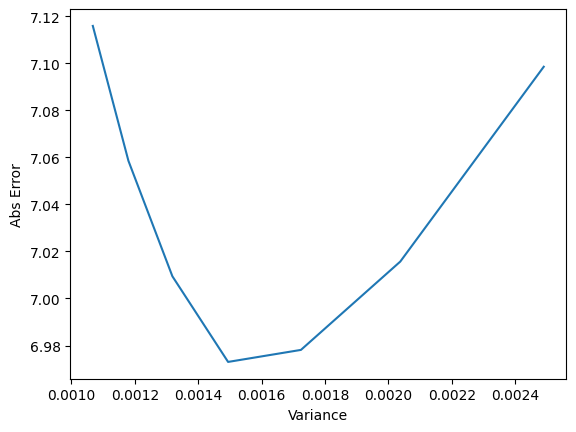

clustersize =  59


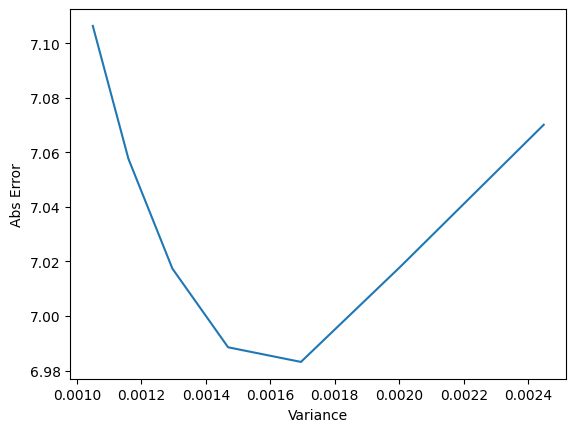

optimal_ws:  [[131.74944074583226, 132.22273652995977, 133.35252037546394, 135.09385336976797, 137.51973604834384, 140.1172170168034, 142.9185003694393], [131.5034647005659, 132.11572273137693, 133.43920321488295, 135.04545388335822, 137.339345375746, 139.90227813162755, 142.99388806531587], [132.61168437869048, 133.1143348522883, 133.76619961527996, 135.3456285041865, 137.01513763362078, 139.03477010869275, 141.14334765705], [133.3508443640529, 133.59897290955377, 134.8344095086342, 136.90630161274063, 139.2614715291535, 141.952598059562, 144.66842579371547], [132.37817543444277, 132.56257092953635, 133.7926213789712, 136.0987038289747, 138.81865558634397, 141.70478906955512, 144.80471732879644], [130.7509353957828, 130.0611185278851, 130.5180931500386, 131.72773683537102, 134.11266630408073, 136.83621156146515, 139.94096551065337], [130.04912357251956, 130.37067028636892, 130.8714301198011, 132.42114677838293, 134.37347402782294, 136.52360278632585, 138.94963099209235]]
optimal_mses:

In [ ]:
def minimise_w(x, lambd, t):
    autovariate = np.matmul(np.transpose(x), x)
    identity = np.identity(x.shape[1])
    covariate = np.matmul(np.transpose(x), t)
    A = autovariate + np.multiply(lambd, identity)
    L = np.linalg.cholesky(A)
    y = np.linalg.solve(L, covariate)
    w = np.linalg.solve(L.T, y)
    return w

def regress_func(x,w):
  return np.matmul(np.transpose(w),x)

def gaussian(mean, variance, x):
  return np.exp(-0.5*np.square(((x-mean)/np.sqrt(variance))))/np.sqrt(2*np.pi*variance)

def get_interval_vect(intervals, variance, x, gauss_fct):
    return gauss_fct(intervals[:, np.newaxis], variance, x)


lower_bound = 0.6
upper_bound = 3.2


optimal_lambdas = []
optimal_ws = []
optimal_mses = []
optimal_abs_errors = []
variances = []
intervals = []

np.set_printoptions(precision=2)


mincluster = 53
maxcluster = 60
for clustersize in range(mincluster,maxcluster):
  print("clustersize = ", clustersize)
  intervallist = np.linspace(start = lower_bound, stop = upper_bound, num = clustersize, dtype = float)
  intervals.append([intervallist])
  variances.append([])
  optimal_lambdas.append([])
  optimal_ws.append([])
  optimal_mses.append([])
  optimal_abs_errors.append([])
  for m in range(18,44, 4):
    cluster10 = np.zeros([Z.shape[0],clustersize,15])
    variance = (upper_bound-lower_bound)/(m*clustersize)
    variances[clustersize-mincluster].append(variance)
    for k in range(Z.shape[0]):
      for i in range(distance_matrix.shape[1]):
        if index_list[k,i] < 1000 and distance_matrix[k,i]!= 0:
          cluster10[k,:,index_list[k,i]] += get_interval_vect(intervallist,variance, distance_matrix[k,i], gaussian).transpose()[0]

    distance_pairs = np.reshape(cluster10, [cluster10.shape[0], clustersize*15])
    k_fold = 5
    repetitions = 70
    lambdalist_dist_pairs = np.logspace(-0.5,1.8,num=repetitions)
    mselist_dist_pairs = np.zeros(repetitions)
    a = int(distance_pairs.shape[0]/k_fold)

    for count, j in enumerate(lambdalist_dist_pairs):
      mselistinside = np.zeros(k_fold)
      for k in range(k_fold):
        training = np.concatenate((distance_pairs[:k*a], distance_pairs[(k+1)*a:]))
        test = distance_pairs[k*a:(k+1)*a]
        trainingT = np.concatenate((T[:k*a], T[(k+1)*a:]))
        testT = T[k*a:(k+1)*a]
        w = minimise_w(training, j, trainingT)
        A = np.zeros(testT.shape)
        for i in range(A.shape[0]):
          A[i] = regress_func(test[i], w)
        mselistinside[k] = (np.absolute(A - testT)).mean(axis=0)
      mselist_dist_pairs[count] = np.mean(mselistinside)

    optimal_lambda_dist_pairs = lambdalist_dist_pairs[np.argmin(mselist_dist_pairs)]
    optimal_lambdas[clustersize-mincluster].append(optimal_lambda_dist_pairs)
    w_dist_pairs = minimise_w(distance_pairs, optimal_lambda_dist_pairs, T)
    optimal_ws[clustersize-mincluster].append(w_dist_pairs)
    A_dist_pairs = np.zeros(T.shape)
    for i in range(A_dist_pairs.shape[0]):
      A_dist_pairs[i] = regress_func(distance_pairs[i], w_dist_pairs)
    mse_dist_pairs = (np.square(A_dist_pairs - T)).mean(axis=0)
    optimal_mses[clustersize-mincluster].append(mse_dist_pairs)
    abs_error_dist_pairs = (np.absolute(A_dist_pairs - T)).mean(axis=0)
    optimal_abs_errors[clustersize-mincluster].append(abs_error_dist_pairs)

  plt.plot(variances[clustersize-mincluster], optimal_abs_errors[clustersize-mincluster])
  plt.xlabel("Variance")
  plt.ylabel("Abs Error")
  plt.show()


print("optimal_ws: ", optimal_mses)
print("optimal_mses: ", optimal_mses)
print("optimal_abs_errors: ", optimal_abs_errors)
print("variances: ", variances)
print("Intervalls: ", intervallist)

##### This part should be de-commented if one wishes to save the obtained data#######
# import pickle

# with open('optimal_lambdas.pickle', 'wb') as handle:
#     pickle.dump(optimal_lambdas, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('optimal_ws.pickle', 'wb') as handle:
#     pickle.dump(optimal_ws, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('optimal_mses.pickle', 'wb') as handle:
#     pickle.dump(optimal_mses, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('optimal_abs_errors.pickle', 'wb') as handle:
#     pickle.dump(optimal_abs_errors, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('variances.pickle', 'wb') as handle:
#     pickle.dump(variances, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('intervals.pickle', 'wb') as handle:
#     pickle.dump(intervals, handle, protocol=pickle.HIGHEST_PROTOCOL)




Since running the above code takes roughly 1 hour using colab pro, we provide all the gathered data as pickled files.

In [ ]:
##### When loading the provided data make sure to adapt the path to the repository containing the files######
import pickle
with open('/optimal_lambdas.pickle', 'rb') as handle:
    optimal_lambdas1 = pickle.load(handle)

with open('/optimal_ws.pickle', 'rb') as handle:
    optimal_ws1 = pickle.load(handle)

with open('/optimal_mses.pickle', 'rb') as handle:
    optimal_mses1 = pickle.load(handle)

with open('/optimal_abs_errors.pickle', 'rb') as handle:
    optimal_abs_errors1 = pickle.load(handle)

with open('/variances.pickle', 'rb') as handle:
    variances1 = pickle.load(handle)

with open('/intervals.pickle', 'rb') as handle:
    intervals1 = pickle.load(handle)


The best model was found out to be a model that uses 58 intervals, a variance of 0.001494 for each gaussian function and a lambda of 17.11.
This model has an absolute prediction error of 6.973 kcal/mol.


In [ ]:
# best_absolute_error = min(i for i in min(optimal_abs_errors1))
best_absolute_error = np.min(optimal_abs_errors1)
best_absolute_error_index = np.argmin(optimal_abs_errors1)
best_optimal_lambda = optimal_lambdas1[best_absolute_error_index//7][38-7*5]
best_optimal_variance = variances1[best_absolute_error_index//7][38-7*5]
best_optimal_w = optimal_ws1[best_absolute_error_index//7][38-7*5]
print("best_absolute_error: ", best_absolute_error)
print("best_absolute_error_index: ", best_absolute_error_index)
print("best_optimal_lambda: ", optimal_lambdas1[best_absolute_error_index//7][38-7*5])
print("best_optimal_variance: ", variances1[best_absolute_error_index//7][38-7*5])
print("optimal clustersize: ", 58)

best_absolute_error:  6.973029193676704
best_absolute_error_index:  38
best_optimal_lambda:  17.11328304161781
best_optimal_variance:  0.0014942528735632185
optimal clustersize:  58


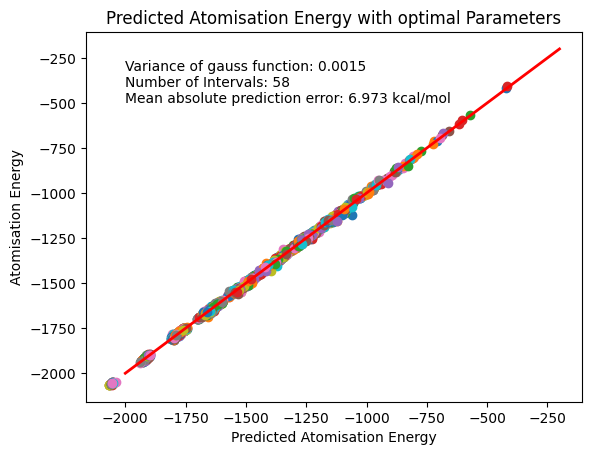

In [ ]:
cluster58 = np.zeros([Z.shape[0],58,15])
for k in range(Z.shape[0]):
  for i in range(distance_matrix.shape[1]):
    if index_list[k,i] < 1000 and distance_matrix[k,i]!= 0:
      cluster58[k,:,index_list[k,i]] += get_interval_vect(np.linspace(start = lower_bound, stop = upper_bound, num = 58, dtype = float),best_optimal_variance, distance_matrix[k,i], gaussian).transpose()[0]

distance_pairs = np.reshape(cluster58, [cluster58.shape[0], 58*15])

for i in range(2000):
    plt.scatter(regress_func(distance_pairs[i],best_optimal_w), T[i])

plt.plot([-2000, -200],[-2000,-200], c="red", linewidth=2)
plt.ylabel("Atomisation Energy")
plt.xlabel("Predicted Atomisation Energy")
plt.title("Predicted Atomisation Energy with optimal Parameters")
plt.text(x=-2000, y=-500, s="Variance of gauss function: 0.0015\nNumber of Intervals: 58\nMean absolute prediction error: 6.973 kcal/mol")
plt.show()

**Plot pairwise potentials**

Since the euclidian distances of the atoms do not correspond to real life values, we performed normalisation of the obtained values in order to plot bond lengths in Ångström. The bond length of the Carbon-Hydrogen bond in the first molecule of the dataset, which is Methane, is 2.064. Since the actual Carbon-Hydrogen bond length is 1.087 Ångström, we multiplied the intervals with 0.527 to convert the distances to Ångström. Plotting the optimal weights of the best fitting regression model against the distances and splitting the plots by atom pair types, one obtaines the pairwise potentials. Indeed in some cases, these potentials fit the real life bond lengths quite nicely. For example, Hydrogen-Oxygen bonds and Hydrogen-Nitrogen bonds are 0.96 Ångström and 1.01 Ångström in length, respectively (Organic Chemistry (Smith)).
Still, in cases where no or only few atom pairs are present in the dataset, the prediction completely differs from reality. This is for example the case in Hydrogen-Hydrogen bonds, which have a length of 0.74 Ångström or the complete lack of prediction values for Sulfur-Sulfur bonds. This was to be expected, as Hydrogen-Hydrogen bonds only form in the case of molecular Hydrogen (Dihydrogen) and Sulfur-Sulfur bonds are not commonly found in organic compounds outside of proteins in the form of disulfide bonds. An interesting observation is the postivie predicted atomisation energy of Carbon-Hydrogen bonds at a bond length of roughly 1.2 Ångström. These bonds could be explained by steric effects in molecules, in which Carbon atoms are forced into an unfavourable geometry (e.g. in a cyclopropane ring) and thus are closer to Hydrogen atoms of neighboring Carbon atoms (i.e. they do not actually form a bond with the respective Hydrogen atom).

In [ ]:
#Carbon-Hydrogen bond length of the qm7 dataset for Methane
print(np.linalg.norm(R[0,0]-R[0,1]))

2.063549


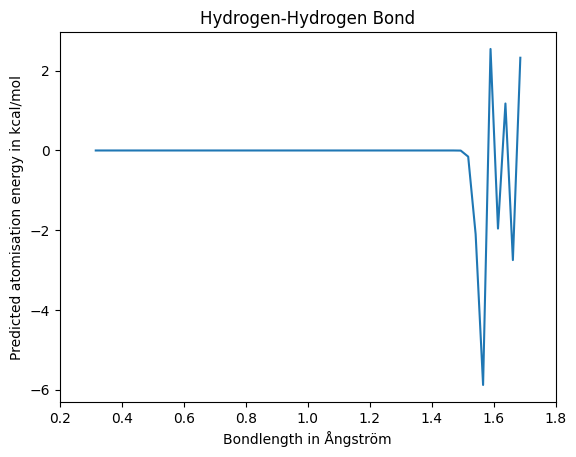

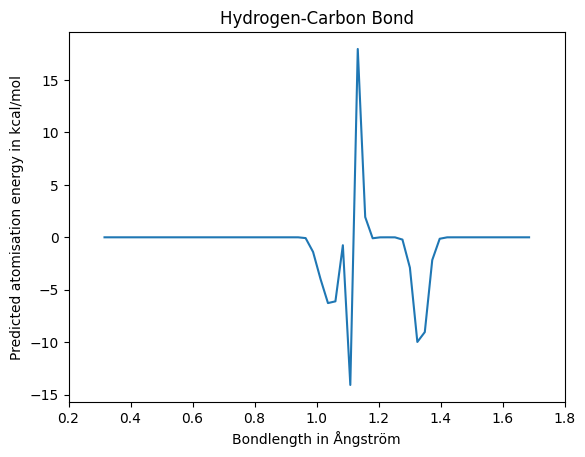

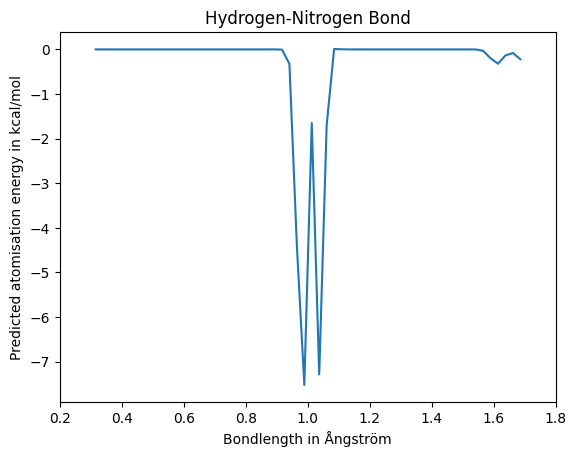

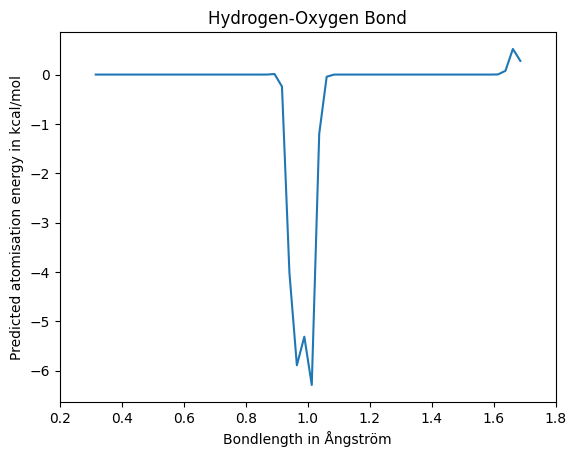

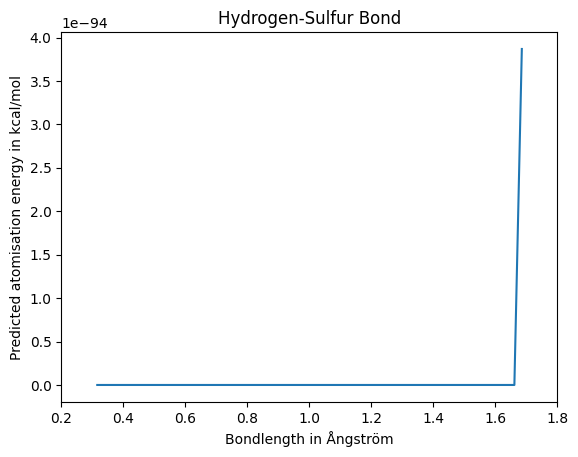

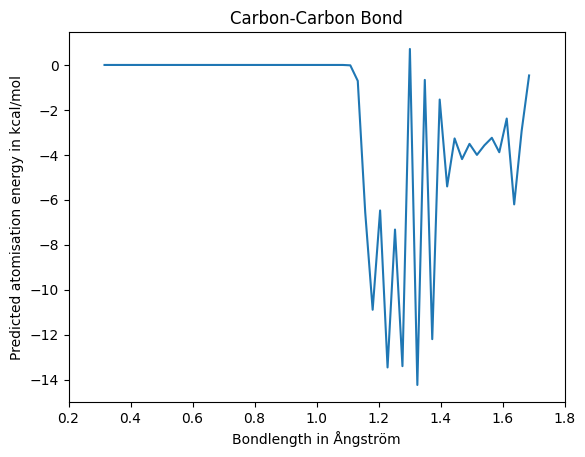

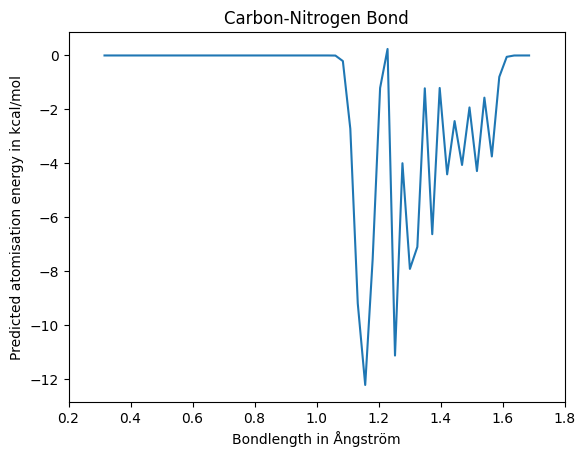

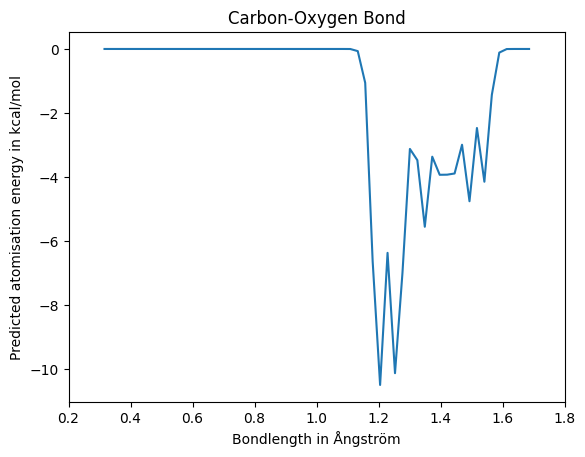

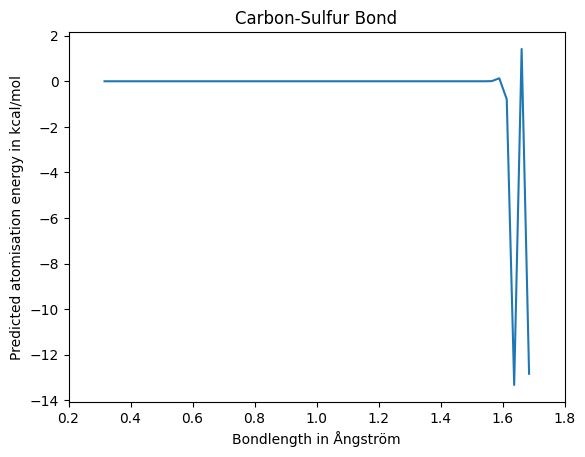

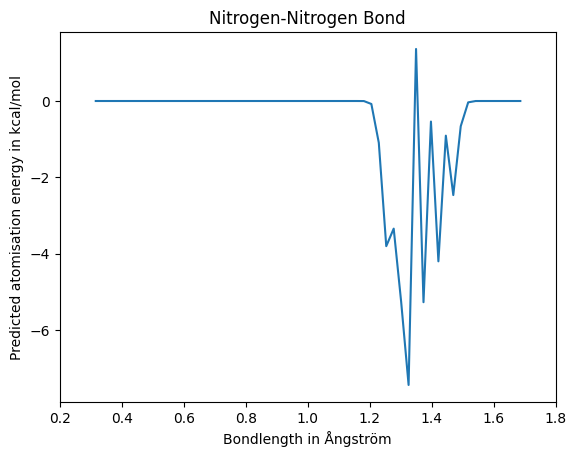

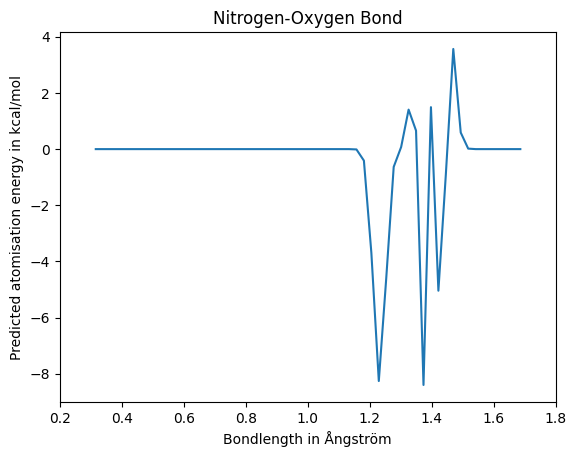

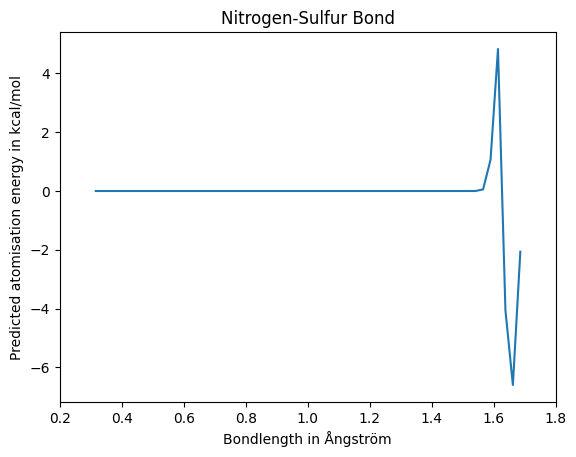

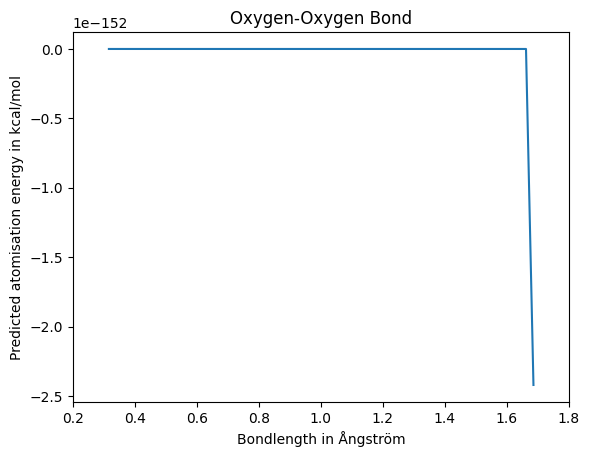

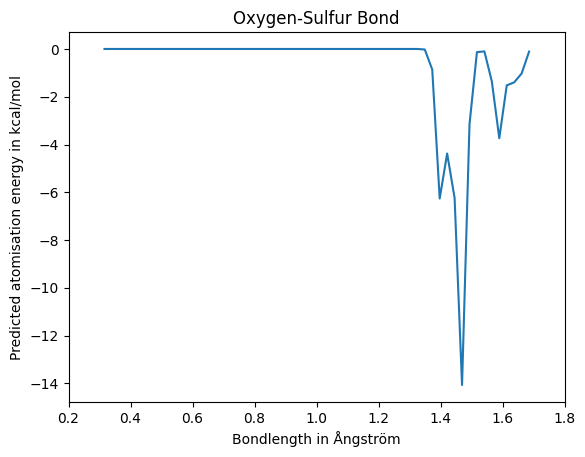

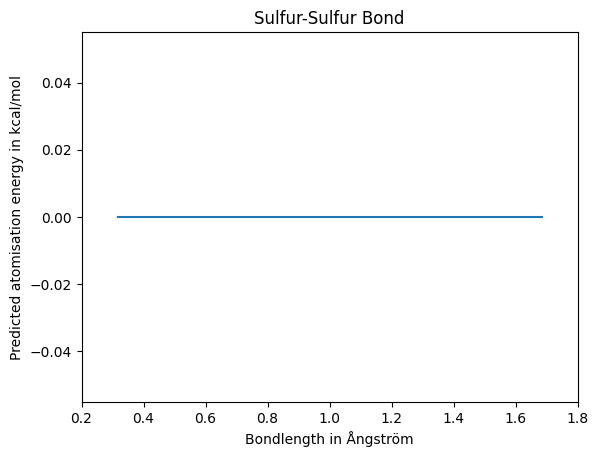

In [ ]:
# pairtypes = {(1,6):1, (1,7):2, (1,8):3, (1,16):4, (6,1):1 ,(6,6):5, (6,7):6, (6,8):7, (6,16):8,
#          (7,1):2, (7,6):6, (7,7):9, (7,8):10, (7,16):11, (8,1):3, (8,6):7, (8,7):10,
#           (8,8):12, (8,16):13, (16,1):4, (16,6):8, (16,7):11, (16,8):13, (16,16):14, (1,1):1}
bondsnames = ["Hydrogen-Hydrogen Bond", "Hydrogen-Carbon Bond", "Hydrogen-Nitrogen Bond", "Hydrogen-Oxygen Bond", "Hydrogen-Sulfur Bond", "Carbon-Carbon Bond", "Carbon-Nitrogen Bond",
              "Carbon-Oxygen Bond", "Carbon-Sulfur Bond", "Nitrogen-Nitrogen Bond", "Nitrogen-Oxygen Bond","Nitrogen-Sulfur Bond", "Oxygen-Oxygen Bond", "Oxygen-Sulfur Bond", "Sulfur-Sulfur Bond"]
intervallist = np.linspace(start = 0.6, stop = 3.2, num = 58, dtype = float)
intervallist = np.dot(0.526766, intervallist)
hh = []
for j in range(15):
  for i in range(58):
    hh.append(best_optimal_w[(i*15)+j])
# plt.plot(intervallist, hh)
# plt.show()
for i in range(15):
  plt.plot(intervallist,[i for i in hh[58*i:58*(i+1)]])
  plt.title(bondsnames[i])
  plt.xlabel("Bondlength in Ångström")
  plt.ylabel("Predicted atomisation energy in kcal/mol")
  plt.xticks(np.linspace(start = 0.2, stop=1.8, num = 9))
  plt.show()